In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.datasets import load_iris

### Implementarea proprie a regresiei logistice cu bgd + plotarea decision boundary

In [10]:
class LogisticRegressionBGD:
    def __init__(self, learning_rate=0.01, epochs=1000, batch_size=32, multi_class=False, n_classes=3):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.multi_class = multi_class
        self.n_classes = n_classes
        self.models = []  # Lista de modele pentru abordarea one-vs-rest
    
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)  # evitam overflow
        return 1 / (1 + np.exp(-z))
    
    def fit_binary(self, X, y):
        """Antreneaza un model binar de regresie logistica"""
        X = np.array(X)
        y = np.array(y)

        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]

        # initializam weights cu valori aleatorii mici
        num_features = X_with_bias.shape[1]
        weights = np.random.randn(num_features) * 0.01

        n_samples = X_with_bias.shape[0]
        
        # lista pentru a stoca cost-ul pe fiecare epoca
        cost_history = []

        # antrenare pe epoci
        for epoch in range(self.epochs):
            # amestecam datele pentru fiecare epoca
            indices = np.random.permutation(n_samples)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]
            
            epoch_cost = 0

            # Procesam fiecare batch
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # calculam predictiile pentru batch folosind sigmoid
                linear_model = X_batch.dot(weights)
                y_pred = self.sigmoid(linear_model)

                # calculam erorile
                errors = y_pred - y_batch

                # calculam gradientul si actualizam weights
                gradient = (1 / len(X_batch)) * X_batch.T.dot(errors)
                weights -= self.learning_rate * gradient
                
                # calculam costul pentru acest batch (cross-entropy loss)
                batch_cost = -np.mean(y_batch * np.log(y_pred + 1e-10) + 
                                     (1 - y_batch) * np.log(1 - y_pred + 1e-10))
                epoch_cost += batch_cost * len(X_batch) / n_samples
            
            # adaugam costul epocii in istoric
            cost_history.append(epoch_cost)

        return {'weights': weights, 'cost_history': cost_history}
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        if self.multi_class:
            # Abordare one-vs-rest pentru clasificare multi-clasa
            self.classes_ = np.unique(y)
            
            for i, cls in enumerate(self.classes_):
                print(f"Antrenare model pentru clasa {cls}")
                # Cream un set de date binar pentru clasa curenta
                y_binary = np.where(y == cls, 1, 0)
                
                # Antrenam un model de regresie logistica pentru clasa curenta
                model = self.fit_binary(X, y_binary)
                self.models.append(model)
                
            return self
        else:
            # Regresie logistica binara standard
            model = self.fit_binary(X, y)
            self.models.append(model)
            self.coef_ = model['weights'][1:]
            self.intercept_ = model['weights'][0]
            self.cost_history = model['cost_history']
            
            return self
    
    def predict_proba(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]
        
        if self.multi_class:
            # Pentru fiecare model (one-vs-rest), calculam probabilitatile
            all_probs = np.zeros((X.shape[0], len(self.classes_)))
            
            for i, model in enumerate(self.models):
                weights = model['weights']
                all_probs[:, i] = self.sigmoid(X_with_bias.dot(weights))
                
            # normalizam probabilitatile pentru a suma 1 pe fiecare rand
            row_sums = all_probs.sum(axis=1)
            all_probs = all_probs / row_sums[:, np.newaxis]
            
            return all_probs
        else:
            # pt cazul binar, returnam probabilitatile pentru ambele clase
            weights = self.models[0]['weights']
            probs_class_1 = self.sigmoid(X_with_bias.dot(weights))
            return np.column_stack((1 - probs_class_1, probs_class_1))
    
    def predict(self, X):
        if self.multi_class:
            probs = self.predict_proba(X)
            return self.classes_[np.argmax(probs, axis=1)]
        else:
            probs = self.predict_proba(X)[:, 1]
            return (probs >= 0.5).astype(int)
    
    def plot_cost_history(self, class_idx=0):
        if not self.multi_class:
            cost_history = self.cost_history
            title = 'Evolutia functiei cost in timpul antrenarii'
        else:
            cost_history = self.models[class_idx]['cost_history']
            title = f'Evolutia functiei cost pentru clasa {self.classes_[class_idx]}'
            
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.epochs + 1), cost_history, 'b-')
        plt.title(title)
        plt.xlabel('Epoca')
        plt.ylabel('Cost')
        plt.grid(True)
        plt.show()
    
    def plot_decision_boundary(self, X, y, feature_idx=(0, 1), feature_names=['Feature 1', 'Feature 2'], title="Frontiera de decizie"):
        # Selecteaza doar cele doua caracteristici specificate
        X_subset = X[:, feature_idx]
        
        if X_subset.shape[1] != 2:
            raise ValueError("Aceasta functie poate fi folosita doar pentru date cu 2 caracteristici")
    
        x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
        y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
        
        # pregatim datele pentru predictie
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # adaugam coloane de zero pentru celelalte caracteristici
        if X.shape[1] > 2:
            extra_features = np.zeros((grid.shape[0], X.shape[1] - 2))
            full_grid = np.zeros((grid.shape[0], X.shape[1]))
            full_grid[:, feature_idx[0]] = grid[:, 0]
            full_grid[:, feature_idx[1]] = grid[:, 1]
        else:
            full_grid = grid
        
        # facem predictiile
        if self.multi_class:
            Z = self.predict(full_grid).reshape(xx.shape)
        else:
            Z = self.predict_proba(full_grid)[:, 1].reshape(xx.shape)
    
        plt.figure(figsize=(10, 8))
        
        if self.multi_class:
            # Pentru multi-class, folosim o paleta de culori potrivita
            plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
            scatter = plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y, cmap='viridis', s=50, edgecolor='k')
        else:
            # Pentru binar, folosim doar 3 niveluri
            plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.4, cmap='bwr')
            scatter = plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y, cmap='bwr', s=50, edgecolor='k')
        
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(title)
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        
        if self.multi_class:
            # legenda pentru clase multiple
            legend1 = plt.legend(*scatter.legend_elements(), title="Clase")
            plt.gca().add_artist(legend1)
        else:
            plt.legend(*scatter.legend_elements(), title="Clase")
            
        plt.grid(True)
        plt.show()

### Executia pe setul de date
#### *plotarea decision boundary pentru fiecare combinatie de atribute doua cate doua
#### *compararea cu regresia logistica din sklearn

Primele 5 rânduri din setul de date iris:
   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Maparea claselor:
Iris-setosa: 0
Iris-versicolor: 1
Iris-virginica: 2

Distribuția claselor în setul nostru de exemple:
Iris-setosa: 50
Iris-versicolor: 50
Iris-virginica: 50

Statistici pentru caracteristicile selectate:
Sepal Length: min=4.30, max=7.90, media=5.84, std=0.83
Sepal Width: min=2.00, max=4.40, media=3.05, std=0.43
Petal Length: min=1.00, max=6.90, media=3.76, std=1.76
Petal Width: min=0.10, max=2.50, media=1.20, std=0.76
Antrenare model pentru clasa 0
Antrenare model pentru clasa 1
Antrenare model pentru clasa 2


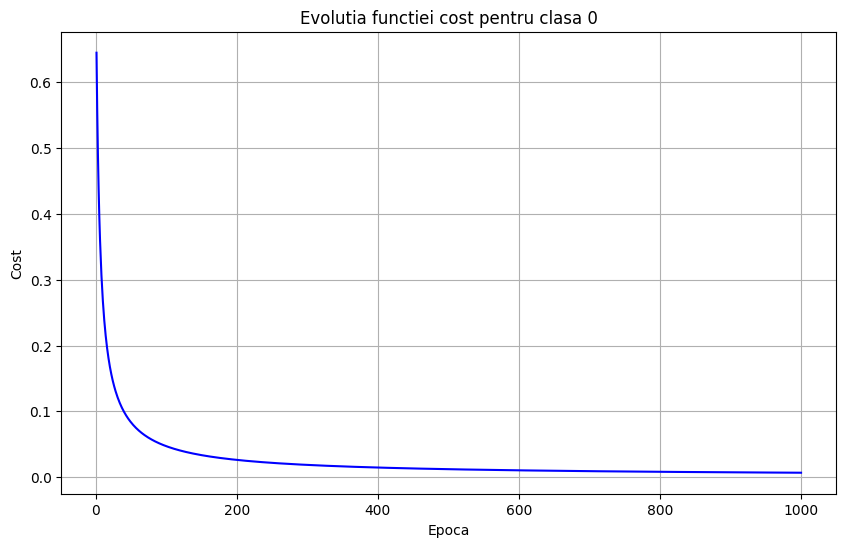

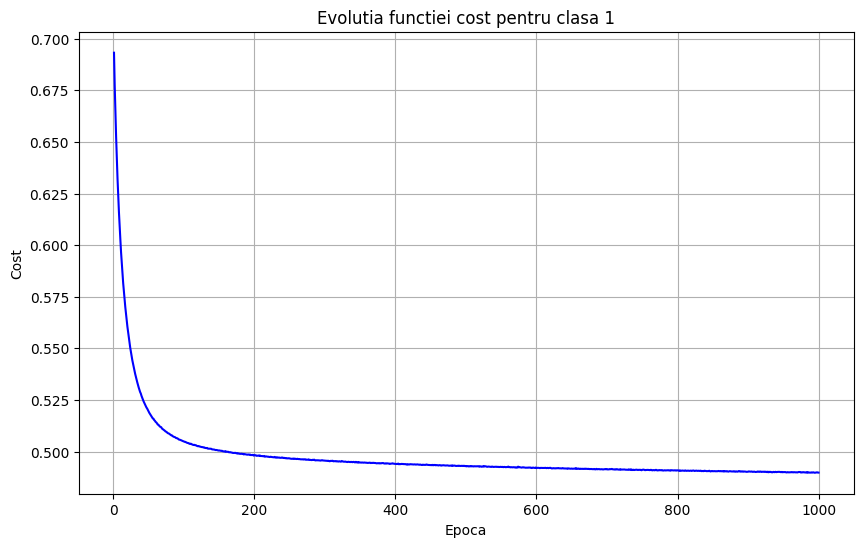

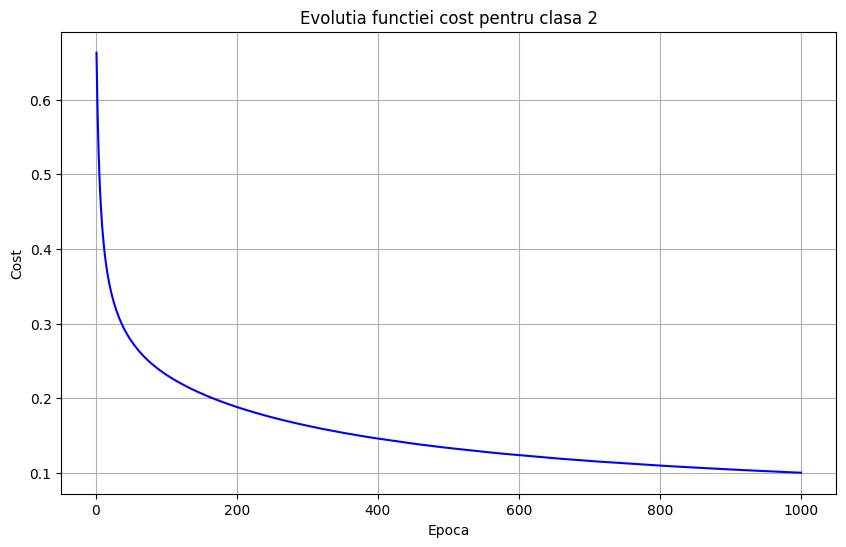

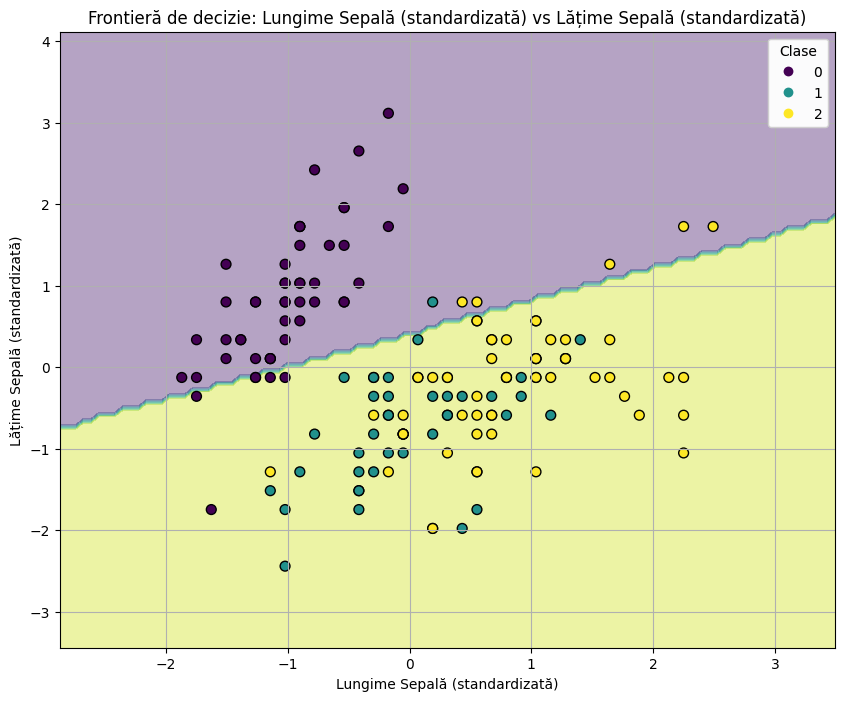

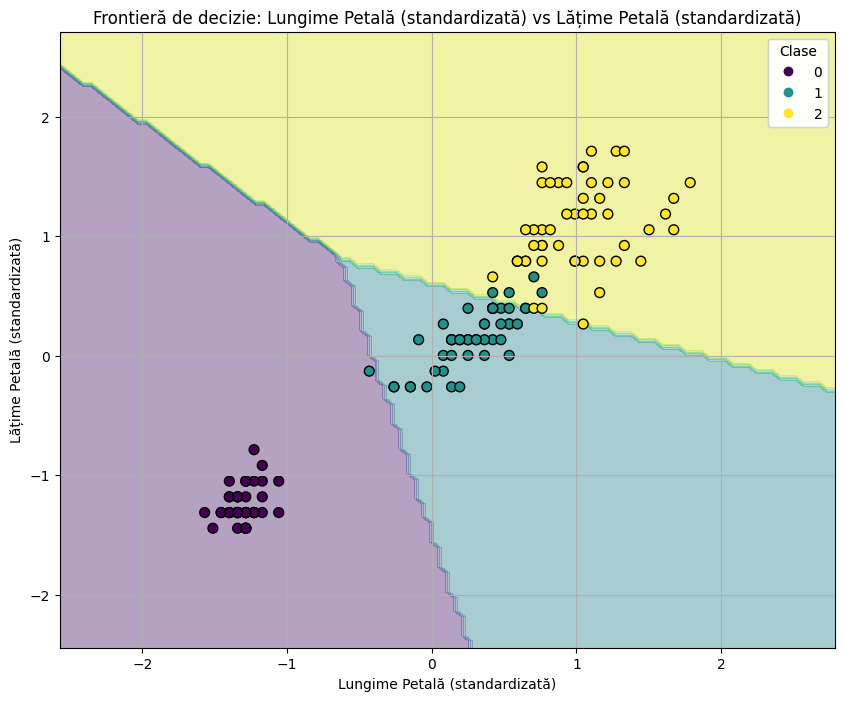

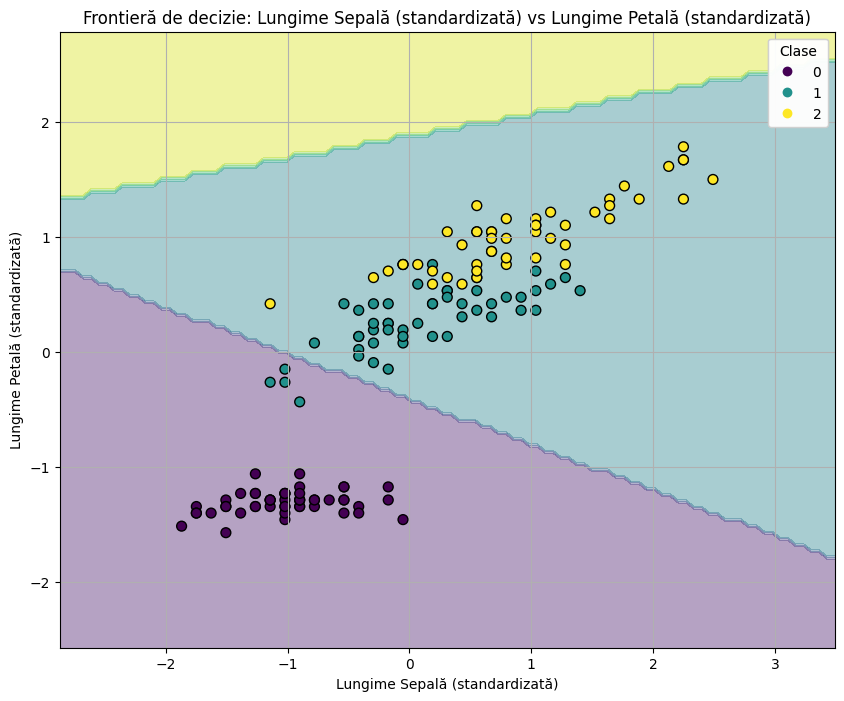

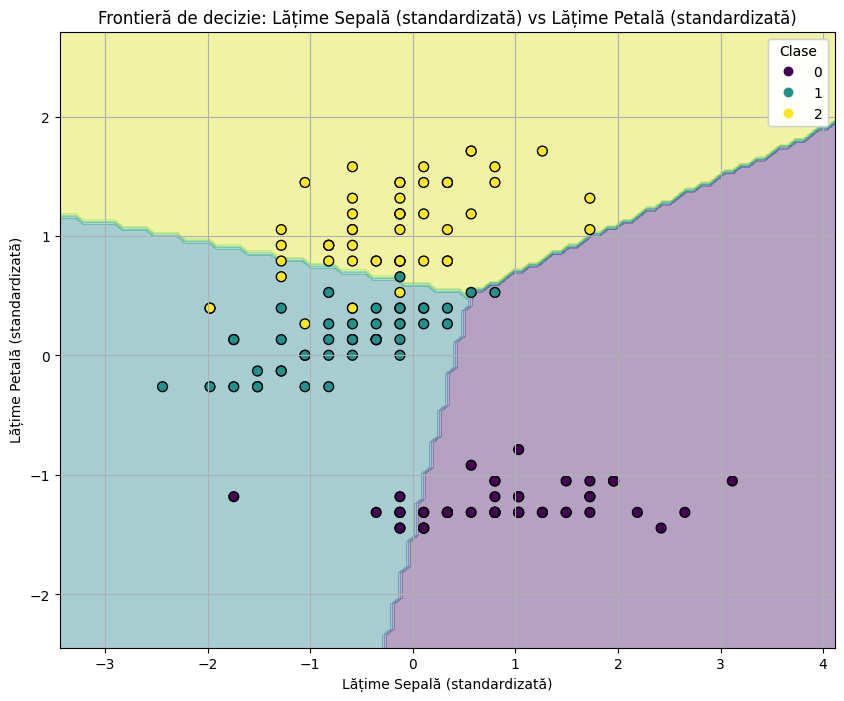


Pentru o floare cu sepala data:
Clasificare: Specia Iris-setosa
Probabilitati pentru fiecare clasa:
  Iris-setosa: 0.9792
  Iris-versicolor: 0.0208
  Iris-virginica: 0.0000

Performanta model LogisticRegressionBGD (implementare proprie):
Acuratete: 0.9466666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.94      0.90      0.92        50
 Iris-virginica       0.90      0.94      0.92        50

       accuracy                           0.95       150
      macro avg       0.95      0.95      0.95       150
   weighted avg       0.95      0.95      0.95       150


Performanță model scikit-learn:
Acuratețe: 0.9466666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.92      0.92      0.92        50
 Iris-virginica       0.92      0.92      0.92        50

       accuracy                     

d:\facultate\semestrul 4\ai\lab6_ai\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


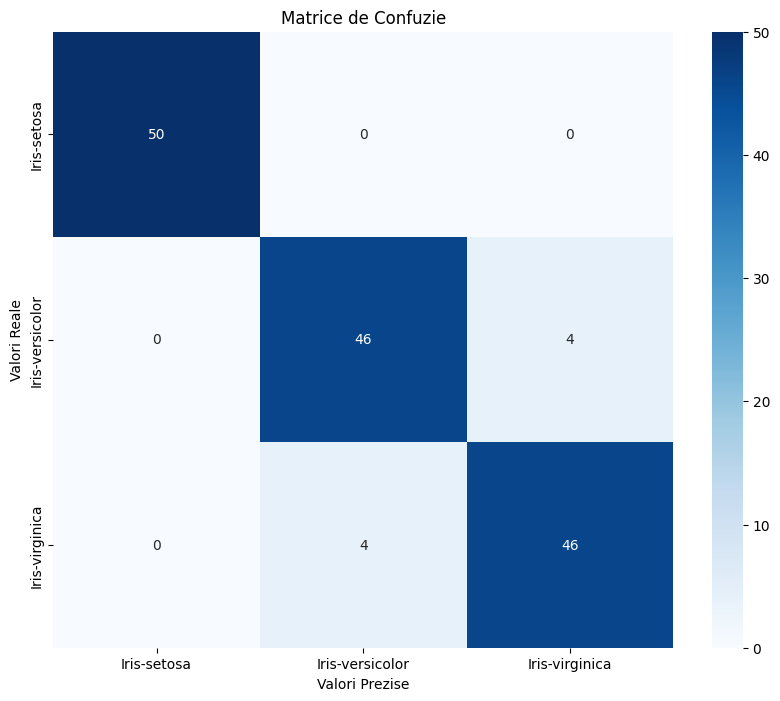

In [ ]:
# definim coloanele pt setul de date
iris_columns = [
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'
]

# incarcam setul de date iris
data = pd.read_csv('./data/iris.data', header=None, names=iris_columns)

# afisam primele cateva randuri pentru a verifica datele
print("Primele 5 rânduri din setul de date iris:")
print(data.head())

# codificam clasele in valori numerice
le = LabelEncoder()
data['class_encoded'] = le.fit_transform(data['class'])
class_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("\nMaparea claselor:")
for cls, code in class_mapping.items():
    print(f"{cls}: {code}")

# extragem caracteristicile si etichetele
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = data['class_encoded'].values

print("\nDistribuția claselor în setul nostru de exemple:")
for cls, code in class_mapping.items():
    print(f"{cls}: {sum(y == code)}")

print("\nStatistici pentru caracteristicile selectate:")
for i, feature in enumerate(['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']):
    print(f"{feature}: min={X[:, i].min():.2f}, max={X[:, i].max():.2f}, media={X[:, i].mean():.2f}, std={X[:, i].std():.2f}")

# normalizam datele
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# antrenam modelul multi-clasa
model = LogisticRegressionBGD(learning_rate=0.01, epochs=1000, batch_size=8, multi_class=True, n_classes=3)
model.fit(X_scaled, y)

# afisam evolutia costului pentru fiecare clasa
for i in range(len(model.classes_)):
    model.plot_cost_history(class_idx=i)

# proiectam datele si afisam frontiera de decizie pt diferite perechi de caracteristici
feature_pairs = [
    ((0, 1), ['Lungime Sepală (standardizată)', 'Lățime Sepală (standardizată)']),
    ((2, 3), ['Lungime Petală (standardizată)', 'Lățime Petală (standardizată)']),
    ((0, 2), ['Lungime Sepală (standardizată)', 'Lungime Petală (standardizată)']),
    ((1, 3), ['Lățime Sepală (standardizată)', 'Lățime Petală (standardizată)'])
]

for feature_idx, feature_names in feature_pairs:
    model.plot_decision_boundary(
        X_scaled, y, 
        feature_idx=feature_idx,
        feature_names=feature_names,
        title=f"Frontieră de decizie: {feature_names[0]} vs {feature_names[1]}"
    )

# predictie pentru cazul specific
sample = np.array([[5.35, 3.85, 1.25, 0.4]])
sample_scaled = scaler.transform(sample)

# facem predictia
prediction = model.predict(sample_scaled)[0]
prediction_proba = model.predict_proba(sample_scaled)[0]

# determinam specia
species = list(class_mapping.keys())[list(class_mapping.values()).index(prediction)]

print(f"\nPentru o floare cu sepala data:")
print(f"Clasificare: Specia {species}")
print(f"Probabilitati pentru fiecare clasa:")
for i, cls in enumerate(class_mapping.keys()):
    print(f"  {cls}: {prediction_proba[i]:.4f}")

# predictii cu modelul implementat manual
y_pred_custom = model.predict(X_scaled)

# acuratete si raport de clasificare
print("\nPerformanta model LogisticRegressionBGD (implementare proprie):")
print("Acuratete:", accuracy_score(y, y_pred_custom))
print(classification_report(y, y_pred_custom, target_names=list(class_mapping.keys())))

# compara cu modelul Scikit-learn
clf = LogisticRegression(multi_class='ovr', max_iter=1000)
clf.fit(X_scaled, y)

# predictii cu modelul scikit-learn
y_pred = clf.predict(X_scaled)
print("\nPerformanță model scikit-learn:")
print("Acuratețe:", accuracy_score(y, y_pred))
print(classification_report(y, y_pred, target_names=list(class_mapping.keys())))

# predictie pentru cazul specific cu scikit-learn
sklearn_prediction = clf.predict(sample_scaled)[0]
sklearn_proba = clf.predict_proba(sample_scaled)[0]
sklearn_species = list(class_mapping.keys())[list(class_mapping.values()).index(sklearn_prediction)]

print(f"\nPredictia cu scikit-learn pentru aceeași floare:")
print(f"Clasificare: Specia {sklearn_species}")
print(f"Probabilități pentru fiecare clasă:")
for i, cls in enumerate(class_mapping.keys()):
    print(f"  {cls}: {sklearn_proba[i]:.4f}")

# cream o matrice de confuzie vizuala
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_mapping.keys()),
            yticklabels=list(class_mapping.keys()))
plt.title('Matrice de Confuzie')
plt.ylabel('Valori Reale')
plt.xlabel('Valori Prezise')
plt.show()
